## [0] Data Setup
This notebook pulls data from the dataset and converts it into the forms that we need for the project, we get all the clinical data and images and convert the data into three sets for side view, bottom view, and a concatenated set with both.

In [1]:
## Import libraries
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import pandas as pd
import os
import pickle
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Read CSV data
meta = pd.read_csv('metadata.csv')
clinical = pd.read_csv('CMMD_clinicaldata_revision.csv')

In [3]:
## Converts a dicom file to a 2D numpy array
def convert_dicom_to_np(dicom):
    data_voi = apply_voi_lut(dicom.pixel_array, dicom)
    data = dicom.pixel_array
    dicom.PhotometricInterpretation
    data_voi = data_voi - np.min(data_voi)
    data_voi = data_voi / np.max(data_voi)
    data_voi = (data_voi * 255).astype(np.uint8)
    return data_voi

In [4]:
## Helper for create_master_lists, gets the orientation of the image and just returns the side
def orientation_to_side(orientation):
    if orientation == 'FR' or orientation == 'R':
        return 'L'
    return 'R'

In [5]:
## Helper for create_master_lists, returns info from clinical data sheet
def pull_clinical_data(ID, side):
    patient_indices = clinical.loc[clinical['ID1'] == ID]
    
    if len(patient_indices) > 2:
        print("Check pull_clinical_data")
        exit()
        
    if ID[1]=='2' and len(patient_indices) == 1:
        index = patient_indices.index[0]
        if not clinical['LeftRight'][index] == side:
            age = clinical['Age'][index]
            abnormality = 'D2 Normal'
            classification = 'D2 Normal'
            subtype = 'D2 Normal'
            return age, abnormality, classification, subtype
        
    for idx in patient_indices.index:
        if not (clinical['LeftRight'][idx] == side):
            continue
        age = clinical['Age'][idx]
        abnormality = clinical['abnormality'][idx]
        classification = clinical['classification'][idx]
        subtype = clinical['subtype'][idx]
        return age, abnormality, classification, subtype

In [6]:
## Function to read from the CSV files and get all of our data into arrays that are indexed the same
def create_master_lists(): 
    images = []
    im_shapes = []
    IDs = []
    ages = []
    abnormalities = []
    classifications = []
    orientations = []
    subtypes = []
    for i in range(0, len(meta.index)): #len(meta.index)
        ID=meta['Subject ID'][i]
        for j in range(1, meta['Number of Images'][i]+1):
            img_name = "1-" + str(j) + ".dcm"
            path = os.path.join(meta['File Location'][i], img_name)
            
            dicom = pydicom.read_file(path)
            
            orientation = dicom.PatientOrientation[1]
            side = orientation_to_side(orientation)
            age, abnormality, classification, subtype = pull_clinical_data(ID, side)
            
            img = convert_dicom_to_np(dicom)
            images.append(img)
            im_shapes.append(np.shape(img))
            IDs.append(ID)
            ages.append(age)
            abnormalities.append(abnormality)
            classifications.append(classification)
            orientations.append(orientation)
            subtypes.append(subtype)
       
    return images, im_shapes, IDs, ages, abnormalities, classifications, orientations, subtypes

In [7]:
## Create data arrays
images, im_shapes, IDs, ages, abnormalities, classifications, orientations, subtypes = create_master_lists()

Wall time: 0 ns


In [8]:
# Save data arrays
with open('images.pkl', 'wb') as f:
    pickle.dump(images, f)
with open('im_shapes.pkl', 'wb') as f:
    pickle.dump(im_shapes, f)    
with open('IDs.pkl', 'wb') as f:
    pickle.dump(IDs, f)
with open('ages.pkl', 'wb') as f:
    pickle.dump(ages, f)  
with open('abnormalities.pkl', 'wb') as f:
    pickle.dump(abnormalities, f)
with open('classifications.pkl', 'wb') as f:
    pickle.dump(classifications, f)   
with open('orientations.pkl', 'wb') as f:
    pickle.dump(orientations, f)
with open('subtypes.pkl', 'wb') as f:
    pickle.dump(subtypes, f) 

In [2]:
# Reload data arrays if needed
with open('images.pkl', 'rb') as f:
    images = pickle.load(f)
with open('im_shapes.pkl', 'rb') as f:
    im_shapes = pickle.load(f)    
with open('IDs.pkl', 'rb') as f:
    IDs = pickle.load(f)
with open('ages.pkl', 'rb') as f:
    ages = pickle.load(f)  
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)   
with open('orientations.pkl', 'rb') as f:
    orientations = pickle.load(f)
with open('subtypes.pkl', 'rb') as f:
    subtypes = pickle.load(f) 

Wall time: 23.9 ms


In [10]:
## Function to rescale images in a list (functionality that skimage.transform.resize doesn't have)
def rescale_images(input_images, scale):
    new_list = []
    for image in input_images:
        new_list.append(resize(image, scale))
    return new_list

In [5]:
## Set scale (determined by RAM needs in eigenvector creation ((row*col)^2) covariance matrix of floats) 
scale = (162, 135)
np_scaled_images = np.array(rescale_images(images, scale))
## np_scaled_images shape is (index, rows, cols)
print(np_scaled_images.shape)

(5150, 162, 135)
Wall time: 998 µs


In [2]:
## Save/reload np_scaled_images
with open('np_scaled_images.npy', 'wb') as f:
    pickle.dump(np_scaled_images, f)
with open('np_scaled_images.npy', 'rb') as f:
    np_scaled_images = pickle.load(f)

In [14]:
## This function will flip the right side images to the left for better more consistent data to train on
## Takes (index, row, col) and returns (index, row, col)
def flip_list(np_imgs, to_print=False):
    flip_list=[]
    for q in range(0,len(np_imgs)):
        if orientations[q]=='L' or orientations[q]=='FL': #flipping the right images
            flip_list.append(np.flip(np_imgs[q],1)) #the integer there is the axis being flipped
        else:
            flip_list.append(np_imgs[q])
    np_flip_list = np.array(flip_list)
    
    if to_print:
        print(f'len(np_imgs)={len(np_imgs)}')
        print(f'len(orientations)={len(orientations)}')
        print('list of flipped images')
        print(f'len(flip_list)={len(flip_list)}')
        print(f'flip_list[0].shape={flip_list[0].shape}')
        print(f"np_flip_list.shape={np_flip_list.shape}")
    return np_flip_list

In [51]:
np_flipped_images = flip_list(np_scaled_images, True)

len(np_imgs)=5150
len(orientations)=5150
list of flipped images
len(flip_list)=5150
flip_list[0].shape=(162, 135)
np_flip_list.shape=(5150, 162, 135)


In [52]:
## This function will splits the images into three groups side view, bottom view, and a combined concatenated view
## Takes (index, rows, cols) returns three np arrays with images in flattened form with shape (index, rows*cols)
def create_side_bottom_concat(np_imgs, to_print=False, orients=orientations):
    side=[]
    below=[]
    flattened_imgs = np_imgs.reshape(np_imgs.shape[0], np_imgs.shape[1]*np_imgs.shape[2])
    if to_print:
        print(flattened_imgs.shape)
    for i in range(0, flattened_imgs.shape[0]):
        if len(orients[i]) == 2:
            side.append(flattened_imgs[i])
        else:
            below.append(flattened_imgs[i])   
    side = np.array(side)
    below = np.array(below)
    concat = np.concatenate((side, below), 1)
    if to_print:
        print('\nconcatenated images')
        print(f'concat.shape={concat.shape}')
        print('\nside images')
        print(f'side.shape={side.shape}')
        print('\nbelow images')
        print(f'below.shape={below.shape}')
    return side, below, concat

In [53]:
## Create side, below, and concat img arrays
side_imgs, below_imgs, concat_imgs = create_side_bottom_concat(np_flipped_images, True)

(5150, 21870)

concatenated images
concat.shape=(2575, 43740)

side images
side.shape=(2575, 21870)

below images
below.shape=(2575, 21870)


In [3]:
## Save/reopen new arrays
with open('side_imgs.npy', 'wb') as f:
    pickle.dump(side_imgs, f)
with open('below_imgs.npy', 'wb') as f:
    pickle.dump(below_imgs, f)
with open('concat_imgs.npy', 'wb') as f:
    pickle.dump(concat_imgs, f)

with open('side_imgs.npy', 'rb') as f:
    side_imgs = pickle.load(f)
with open('below_imgs.npy', 'rb') as f:
    below_imgs = pickle.load(f) 
with open('concat_imgs.npy', 'rb') as f:
    concat_imgs = pickle.load(f) 

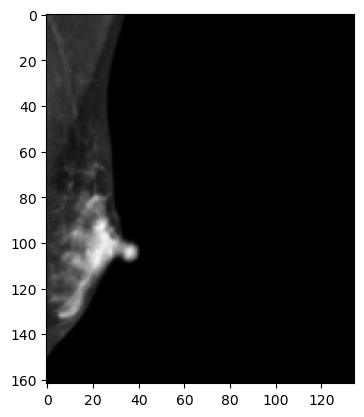

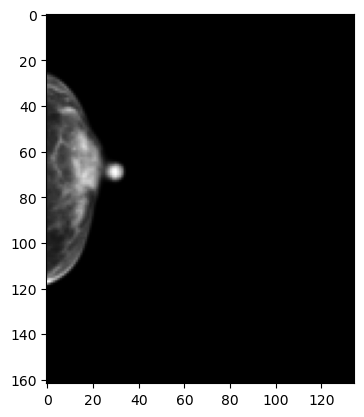

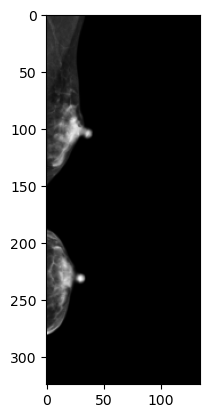

In [8]:
## Display each image type
plt.figure()
plt.imshow(side_imgs[0].reshape(scale), cmap='gray')
plt.figure()
plt.imshow(below_imgs[0].reshape(scale), cmap='gray')
plt.figure()
plt.imshow(concat_imgs[0].reshape((scale[0]*2, scale[1])), cmap='gray')

In [80]:
## define the keys randomly for picking the training and test sets

##DO NOT RERUN AFTER RUNNING ONCE, VERY IMPORTANT TO MAINTAIN THIS SET
keys = np.arange(0,side_imgs.shape[0])
np.random.shuffle(keys)

##########################################################
# Note to grader I'm not going to uncomment this below   #
# but you do need to uncomment and run the dump function #
##########################################################
# with open('OFFICIAL_keys.pkl', 'wb') as f:
#     pickle.dump(keys, f)

with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)

## Define train/test/validation at 80/10/10 split
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

In [4]:
## Simple function to print the number of each class of image
def print_classifications(classes):
    norm_count, malig_count, benign_count = 0, 0, 0
    for c in classes: 
        if c == "D2 Normal":
            norm_count+=1
        if c == "Benign":
            benign_count+=1
        if c == "Malignant":
            malig_count+=1
    print(f"Norm: {norm_count}, Malignant: {malig_count}, Benign: {benign_count}")

In [5]:
## See how many of each class there are
print_classifications(classifications)

Norm: 1444, Malignant: 2594, Benign: 1112
